# Package

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
import pytorch_lightning as pl
from pytorch_lightning import loggers
from pytorch_lightning.callbacks import ModelCheckpoint

In [2]:
%load_ext autoreload
%autoreload 2

# Set up environment

In [3]:
device = "cuda" if torch.cuda.is_available else "cpu"

def format_bytes(size):
    # 2**10 = 1024
    power = 2**10
    n = 0
    power_labels = {0 : '', 1: 'kilo', 2: 'mega', 3: 'giga', 4: 'tera'}
    while size > power:
        size /= power
        n += 1
    return "%.2f" % size, power_labels[n] + 'bytes'

torch.cuda.get_device_name(), format_bytes(torch.cuda.get_device_properties(device).total_memory)

('GeForce GTX 1080 Ti', ('10.92', 'gigabytes'))

# Load data

In [4]:
from preprocessing.load_dataset import raw_to_dict

In [5]:
# trainset, valset = raw_to_dict(data_mode = "small")
trainset, valset = raw_to_dict()

  0%|          | 0/117273 [00:00<?, ?it/s]


>> Loading msimut at /home/kientiet/Documents/My Project/python/ucla-cs168/data/msimut
>> Total running 75039

>> Loading msimut at /home/kientiet/Documents/My Project/python/ucla-cs168/data/mss


100%|██████████| 117273/117273 [00:00<00:00, 944048.65it/s]


>> Total running 117273

>> Splitting the dataset

>> From dictionary to data instance

>> Done!


In [8]:
batch_size = 16
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = 4)
valloader = torch.utils.data.DataLoader(valset, batch_size = batch_size, num_workers = 4)
len(trainloader), len(valloader)

(9432, 6242)

torch.Size([16, 3, 224, 224]) torch.Size([16])


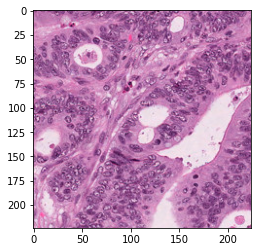

In [7]:
images, labels = next(iter(trainloader))

print(images.shape, labels.shape)
def imshow(img):
    inp = img.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    # plt.show()

imshow(images[0])

# BagNet Orginial 

In [9]:
from trainer.bagnet_trainer import BagNetTrainer

In [10]:
bagnet_trainer = BagNetTrainer(trainloader, valloader, num_cycle = 5)
max_epochs = bagnetorg_trainer.get_max_epochs()

In [11]:
checkpoint_path = os.path.join(os.getcwd(), "checkpoint", "bagnet")
checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    save_top_k = 5,
    verbose = True,
    monitor = 'val_loss',
    mode = 'min'
)

checkpoint_path

/home/kientiet/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: Checkpoint directory /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/bagnetorg exists and is not empty with save_top_k != 0.All files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)


'/home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/bagnetorg'

In [12]:
tb_logger = loggers.TensorBoardLogger('logs/', name = "bagnet")
trainer = pl.Trainer(checkpoint_callback = checkpoint_callback,
                     nb_sanity_val_steps=0, 
                     max_epochs = max_epochs, 
                     gpus = -1, 
                    logger = tb_logger
                    )

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


## Learning rate finder

In [13]:
lr_finder = trainer.lr_find(bagnet_trainer)

INFO:lightning:
    | Name                        | Type              | Params
--------------------------------------------------------------
0   | criterion                   | BCEWithLogitsLoss | 0     
1   | model                       | BagNet            | 18 M  
2   | model.conv1                 | Conv2d            | 192   
3   | model.conv2                 | Conv2d            | 36 K  
4   | model.bn1                   | BatchNorm2d       | 128   
5   | model.relu                  | ReLU              | 0     
6   | model.layer1                | Sequential        | 150 K 
7   | model.layer1.0              | Bottleneck        | 75 K  
8   | model.layer1.0.conv1        | Conv2d            | 4 K   
9   | model.layer1.0.bn1          | BatchNorm2d       | 128   
10  | model.layer1.0.conv2        | Conv2d            | 36 K  
11  | model.layer1.0.bn2          | BatchNorm2d       | 128   
12  | model.layer1.0.conv3        | Conv2d            | 16 K  
13  | model.layer1.0.bn3          | Bat

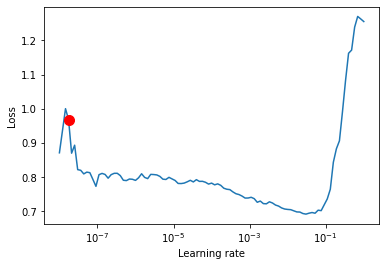

In [14]:
fig = lr_finder.plot(suggest = True)

In [15]:
bagnet_trainer.base_lr = 8e-5
bagnet_trainer.max_lr = 8e-3
bagnet_trainer.configure_optimizers()

SGD (
Parameter Group 0
    base_momentum: 0.85
    dampening: 0
    initial_lr: 0.00032
    lr: 0.00031999999999999997
    max_lr: 0.008
    max_momentum: 0.95
    min_lr: 3.2e-08
    momentum: 0.95
    nesterov: False
    weight_decay: 0.001
)

## Train the model

In [16]:
trainer.fit(bagnet_trainer)

INFO:lightning:
    | Name                        | Type              | Params
--------------------------------------------------------------
0   | criterion                   | BCEWithLogitsLoss | 0     
1   | model                       | BagNet            | 18 M  
2   | model.conv1                 | Conv2d            | 192   
3   | model.conv2                 | Conv2d            | 36 K  
4   | model.bn1                   | BatchNorm2d       | 128   
5   | model.relu                  | ReLU              | 0     
6   | model.layer1                | Sequential        | 150 K 
7   | model.layer1.0              | Bottleneck        | 75 K  
8   | model.layer1.0.conv1        | Conv2d            | 4 K   
9   | model.layer1.0.bn1          | BatchNorm2d       | 128   
10  | model.layer1.0.conv2        | Conv2d            | 36 K  
11  | model.layer1.0.bn2          | BatchNorm2d       | 128   
12  | model.layer1.0.conv3        | Conv2d            | 16 K  
13  | model.layer1.0.bn3          | Bat

INFO:lightning:
Epoch 00001: val_loss reached 0.81284 (best 0.81284), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/bagnetorg/epoch=1_v0.ckpt as top 5


INFO:lightning:
Epoch 00002: val_loss reached 0.73171 (best 0.73171), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/bagnetorg/epoch=2_v0.ckpt as top 5


INFO:lightning:
Epoch 00003: val_loss reached 0.70236 (best 0.70236), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/bagnetorg/epoch=3_v1.ckpt as top 5


INFO:lightning:
Epoch 00004: val_loss reached 1.71332 (best 0.70236), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/bagnetorg/epoch=4_v0.ckpt as top 5


INFO:lightning:
Epoch 00005: val_loss reached 1.51672 (best 0.70236), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/bagnetorg/epoch=5_v1.ckpt as top 5


INFO:lightning:
Epoch 00006: val_loss reached 0.66435 (best 0.66435), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/bagnetorg/epoch=6_v0.ckpt as top 5


INFO:lightning:
Epoch 00007: val_loss reached 0.09921 (best 0.09921), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/bagnetorg/epoch=7.ckpt as top 5


INFO:lightning:
Epoch 00008: val_loss  was not in top 5


INFO:lightning:
Epoch 00009: val_loss reached 0.58782 (best 0.09921), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/bagnetorg/epoch=9_v1.ckpt as top 5


INFO:lightning:
Epoch 00010: val_loss reached 0.41174 (best 0.09921), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/bagnetorg/epoch=10_v0.ckpt as top 5


INFO:lightning:
Epoch 00011: val_loss reached 0.11989 (best 0.09921), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/bagnetorg/epoch=11_v0.ckpt as top 5


INFO:lightning:
Epoch 00012: val_loss  was not in top 5


INFO:lightning:
Epoch 00013: val_loss reached 0.53442 (best 0.09921), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/bagnetorg/epoch=13_v1.ckpt as top 5


INFO:lightning:
Epoch 00014: val_loss reached 0.45724 (best 0.09921), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/bagnetorg/epoch=14_v1.ckpt as top 5


INFO:lightning:
Epoch 00015: val_loss reached 0.20693 (best 0.09921), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/bagnetorg/epoch=15_v0.ckpt as top 5


INFO:lightning:
Epoch 00016: val_loss  was not in top 5


INFO:lightning:
Epoch 00017: val_loss  was not in top 5


INFO:lightning:
Epoch 00018: val_loss  was not in top 5


INFO:lightning:
Epoch 00019: val_loss reached 0.31336 (best 0.09921), saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/bagnetorg/epoch=19_v0.ckpt as top 5


1